In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import random
from random import choice, shuffle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [3]:
random.seed(12345)
train = pd.read_csv('saratoga.csv')
x_train = np.array(train.iloc[:, 1:], dtype='float32')

print(train)

       Price  Lot.Size  Waterfront  Age  Land.Value  New.Construct  \
0     132500      0.09           0   42       50000              0   
1     181115      0.92           0    0       22300              0   
2     109000      0.19           0  133        7300              0   
3     155000      0.41           0   13       18700              0   
4      86060      0.11           0    0       15000              1   
5     120000      0.68           0   31       14000              0   
6     153000      0.40           0   33       23300              0   
7     170000      1.21           0   23       14600              0   
8      90000      0.83           0   36       22200              0   
9     122900      1.94           0    4       21200              0   
10    325000      2.29           0  123       12600              0   
11    120000      0.92           0    1       22300              0   
12     85860      8.97           0   13        4800              0   
13     97000      0.

In [4]:
def kmeans(x, n_features, n_clusters, n_max_steps=10000, early_stop=0.0):
    input_vec = tf.constant(x, dtype=tf.float32)
    centroids = tf.Variable(tf.slice(tf.random_shuffle(input_vec), [0, 0], [n_clusters, -1]), dtype=tf.float32)
    old_centroids = tf.Variable(tf.zeros([n_clusters, n_features]), dtype=tf.float32)
    centroid_distance = tf.Variable(tf.zeros([n_clusters, n_features]))
    expanded_vectors = tf.expand_dims(input_vec, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)

    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)

    assignments = tf.argmin(distances, 0)
    
    means = tf.concat([tf.reduce_mean(
        tf.gather(input_vec, tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])),
        reduction_indices=[1]) for c in range(n_clusters)], 0)

    save_old_centroids = tf.assign(old_centroids, centroids)

    update_centroids = tf.assign(centroids, means)
    init_op = tf.global_variables_initializer()

    performance = tf.assign(centroid_distance, tf.subtract(centroids, old_centroids))
    check_stop = tf.reduce_sum(tf.abs(performance))

    with tf.Session() as sess:
        sess.run(init_op)
        for step in range(n_max_steps):
            sess.run(save_old_centroids)
            _, centroid_values, assignment_values = sess.run(
                [update_centroids, centroids, assignments])            
            sess.run(check_stop)
            current_stop_coeficient = check_stop.eval()
            if current_stop_coeficient <= early_stop:
                break
    return centroid_values, assignment_values


In [5]:
centers, cluster_assignments = kmeans(x_train, len(x_train[0]), 5)
pca_model = PCA(n_components=3)
reduced_data = pca_model.fit_transform(x_train)
reduced_centers = pca_model.transform(centers)

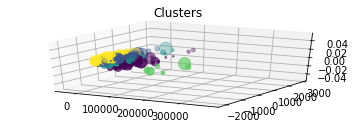

In [6]:
plt.subplot(212, projection='3d')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=cluster_assignments)
plt.title("Clusters")
plt.show()

In [7]:
def kmeans(x, n_features, n_clusters, n_max_steps=10000, early_stop=0.0):
    input_vec = tf.constant(x, dtype=tf.float32)
    centroids = tf.Variable(tf.slice(tf.random_shuffle(input_vec), [0, 0], [n_clusters, -1]), dtype=tf.float32)
    old_centroids = tf.Variable(tf.zeros([n_clusters, n_features]), dtype=tf.float32)
    centroid_distance = tf.Variable(tf.zeros([n_clusters, n_features]))
    expanded_vectors = tf.expand_dims(input_vec, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)

    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)

    assignments = tf.argmin(distances, 0)
    
    means = tf.concat([tf.reduce_mean(
        tf.gather(input_vec, tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])),
        reduction_indices=[1]) for c in range(n_clusters)], 0)

    save_old_centroids = tf.assign(old_centroids, centroids)

    update_centroids = tf.assign(centroids, means)
    init_op = tf.global_variables_initializer()

    performance = tf.assign(centroid_distance, tf.subtract(centroids, old_centroids))
    check_stop = tf.reduce_sum(tf.abs(performance))
    calc_wss = tf.reduce_sum(tf.reduce_min(distances, 0))

    with tf.Session() as sess:
        sess.run(init_op)
        for step in range(n_max_steps):
            sess.run(save_old_centroids)
            _, centroid_values, assignment_values = sess.run(
                [update_centroids, centroids, assignments])            
            sess.run(calc_wss)
            sess.run(check_stop)
            current_stop_coeficient = check_stop.eval()
            wss = calc_wss.eval()
            print(step, current_stop_coeficient)

            if current_stop_coeficient <= early_stop:
                break
    return centroid_values, assignment_values, wss

In [8]:
wcss_list = []

for i in range(2, 10):
    centers, cluster_assignments, wcss = kmeans(x_train, len(x_train[0]), i)
    wcss_list.append(wcss)

0 30005.143
1 19517.309
2 16513.955
3 9622.424
4 6943.148
5 4182.2593
6 2511.0354
7 1313.4293
8 1154.5005
9 786.4644
10 399.54584
11 201.64493
12 204.6725
13 0.0
0 37762.297
1 19319.953
2 12147.129
3 7405.91
4 8238.817
5 6550.573
6 5599.517
7 5653.2793
8 5834.593
9 8101.5864
10 5284.6685
11 5168.327
12 3951.705
13 4899.3057
14 2099.6145
15 894.5941
16 169.95168
17 86.47856
18 0.0
0 35183.254
1 28534.45
2 22704.89
3 19655.652
4 16399.41
5 12537.771
6 11635.982
7 9858.003
8 11178.191
9 14091.426
10 9456.033
11 8089.565
12 4464.9746
13 3962.8203
14 2215.6333
15 2373.0508
16 2932.0864
17 3555.3965
18 2240.6902
19 23802.975
20 29184.014
21 21836.646
22 16508.295
23 1892.5723
24 8521.853
25 2313.4658
26 1757.2092
27 943.35486
28 916.3015
29 339.38495
30 0.0
0 54819.547
1 30194.74
2 21706.297
3 13362.142
4 35581.938
5 33148.74
6 22771.074
7 17988.72
8 2185.747
9 1390.1672
10 490.5975
11 771.3337
12 347.20886
13 0.0
0 50957.77
1 23263.018
2 12280.526
3 34736.97
4 38136.957
5 24306.37
6 10772.4

Text(0.5,1,'WCSS vs Cluters')

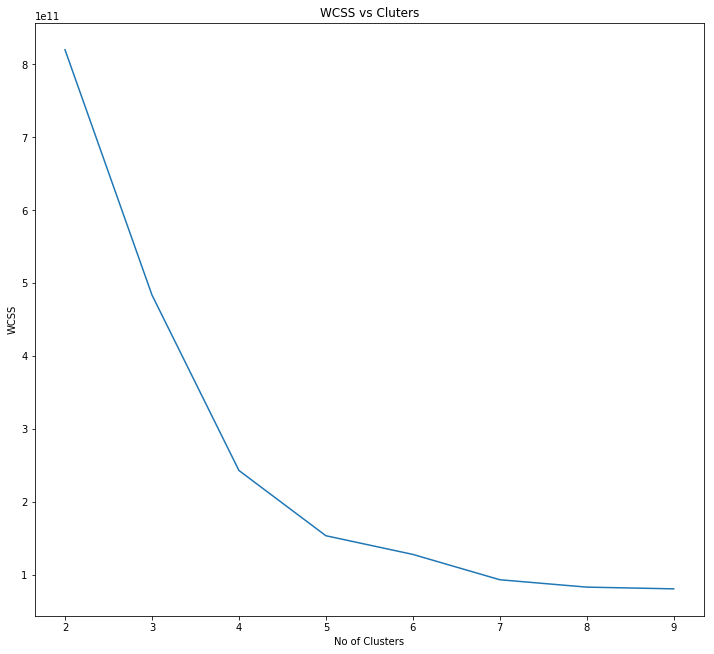

In [9]:
plt.figure(figsize=(12, 24))
plt.subplot(211)
plt.plot(range(2, 10), wcss_list)
plt.xlabel('No of Clusters')
plt.ylabel('WCSS')
plt.title("WCSS vs Cluters")